In [13]:
import numpy as np  
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

In [56]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import col, size, create_map, lit, concat, element_at, when, isnan, count
from pyspark.sql.types import *
from statistics import mean

spark = SparkSession.builder.master('local[*]').config('spark.executor.memory', '16g') \
    .config('spark.driver.memory', '16g').appName('EDA on MSD').getOrCreate()

spark.sparkContext.setLogLevel('ERROR')
sc = spark.sparkContext

print('Reading in Data...')
df = spark.read.load('MSD_GENRE.parquet')
df_year = spark.read.load('MSD_w_Year.parquet')

Reading in Data...


In [57]:
df_year = df_year.filter(df_year['year'] > 1920)

In [58]:
df = df.toPandas()
df_year = df_year.toPandas()

In [59]:
df

,artist_familiarity,artist_hotttnesss,artist_id,artist_name,release,title,duration,end_of_fade_in,key,loudness,...,artist_terms,density,fadedness,variability,key_string,mode_string,tonality,avg_bars_start,avg_beats_start,genre
0,0.558090,0.349841,ARADF5Q1187B98DAE7,Francisco Céspedes,Vida loca,Señora (bonus track),204.53832,0.572,10,-9.840,...,"[los angeles, latin pop, bolero, cuba, disco, ...",2.860100,11.57732,11,LA#,maj,LA# maj,96.38165306818182,98.76446085399449,latin
1,0.485108,0.247341,ARU22AM1187B9961EA,React,Deus Ex Machina,Lost Circles,158.27546,0.172,8,-9.680,...,"[happy hardcore, europop, progressive house, n...",3.392819,6.95446,7,SOL#,maj,SOL# maj,78.24635164705883,78.58425564469914,electronic
2,0.830252,0.507966,ARYO9BU1187B9ADA88,Porcupine Tree,On The Sunday Of Life,Music For The Head,162.06322,1.449,5,-25.745,...,"[experimental rock, art rock, post rock, exper...",1.900493,11.23622,5,FA,maj,FA maj,78.6586212173913,78.6586212173913,rock
3,0.252652,0.309794,ARXW6QA1187B9983C0,Phantomsmasher,Phantomsmasher,Bishop Hopping,382.14485,0.276,3,-6.291,...,"[post rock, grindcore, digital hardcore, avant...",2.239988,32.29885,12,RE#,maj,RE# maj,190.7804549132948,191.3237075886525,country
4,0.927986,0.599860,ARPBTRI1187FB52457,The Game,Doctor's Advocate,Da Shit,323.08200,0.000,7,-2.253,...,"[gangster rap, hardcore rap, west coast rap, c...",3.791607,5.21800,12,SOL,maj,SOL maj,159.45340847826088,160.6727261038961,hip hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9929,0.640757,0.451219,ARMSL551187FB3F4B0,K's Choice,Paradise In Me,My Record Company,222.30159,0.531,4,-7.300,...,"[post-grunge, pop rock, alternative rock, brit...",2.595573,3.37459,9,MI,maj,MI maj,109.2862806122449,110.39954214890017,pop
9930,0.544863,0.387693,ARQN3MO1187B98A811,Channel Live,Armaghetto,Turn It Up,238.81098,0.189,7,-6.338,...,"[gangster rap, hip hop, rap, east coast rap, h...",4.983020,12.29198,8,SOL,maj,SOL maj,118.63113410810811,119.43074638069704,hip hop
9931,0.379735,0.313866,ARY1P2B1187B9B78F5,Mariano Yanani,Babies Go To Sleep,Canon In D Major (J. Pachelbel),192.41751,0.467,2,-16.922,...,"[lullaby, new wave, alternative rock, rock, punk]",2.754427,9.32451,7,RE,maj,RE maj,91.97598092783505,92.9284374168798,metal
9932,0.867259,0.547764,ARHUC691187B9AD27F,The Mars Volta,Deloused in the Comatorium,Eriatarka,380.42077,0.000,6,-3.183,...,"[experimental rock, post rock, progressive met...",2.552437,-0.00023,12,FA#,min,FA# min,190.44517833333333,191.1926428853755,rock


In [61]:
df_filtered = df_year[['duration', 'loudness', 'tempo', 'year', 'density', 
                       'fadedness', 'variability', 'artist_hotttnesss', 'artist_familiarity']]

# df_filtered = df_year[['tempo', 'year', 'density']]

# df_filtered['year'] = df_year[df_year['year'] > 1920]
# df_filtered['tempo'] = df_year[df_year['tempo'] !=0]
# df_filtered['artist_hotttnesss'] = df_year[df_year['artist_hotttnesss'] != 0]

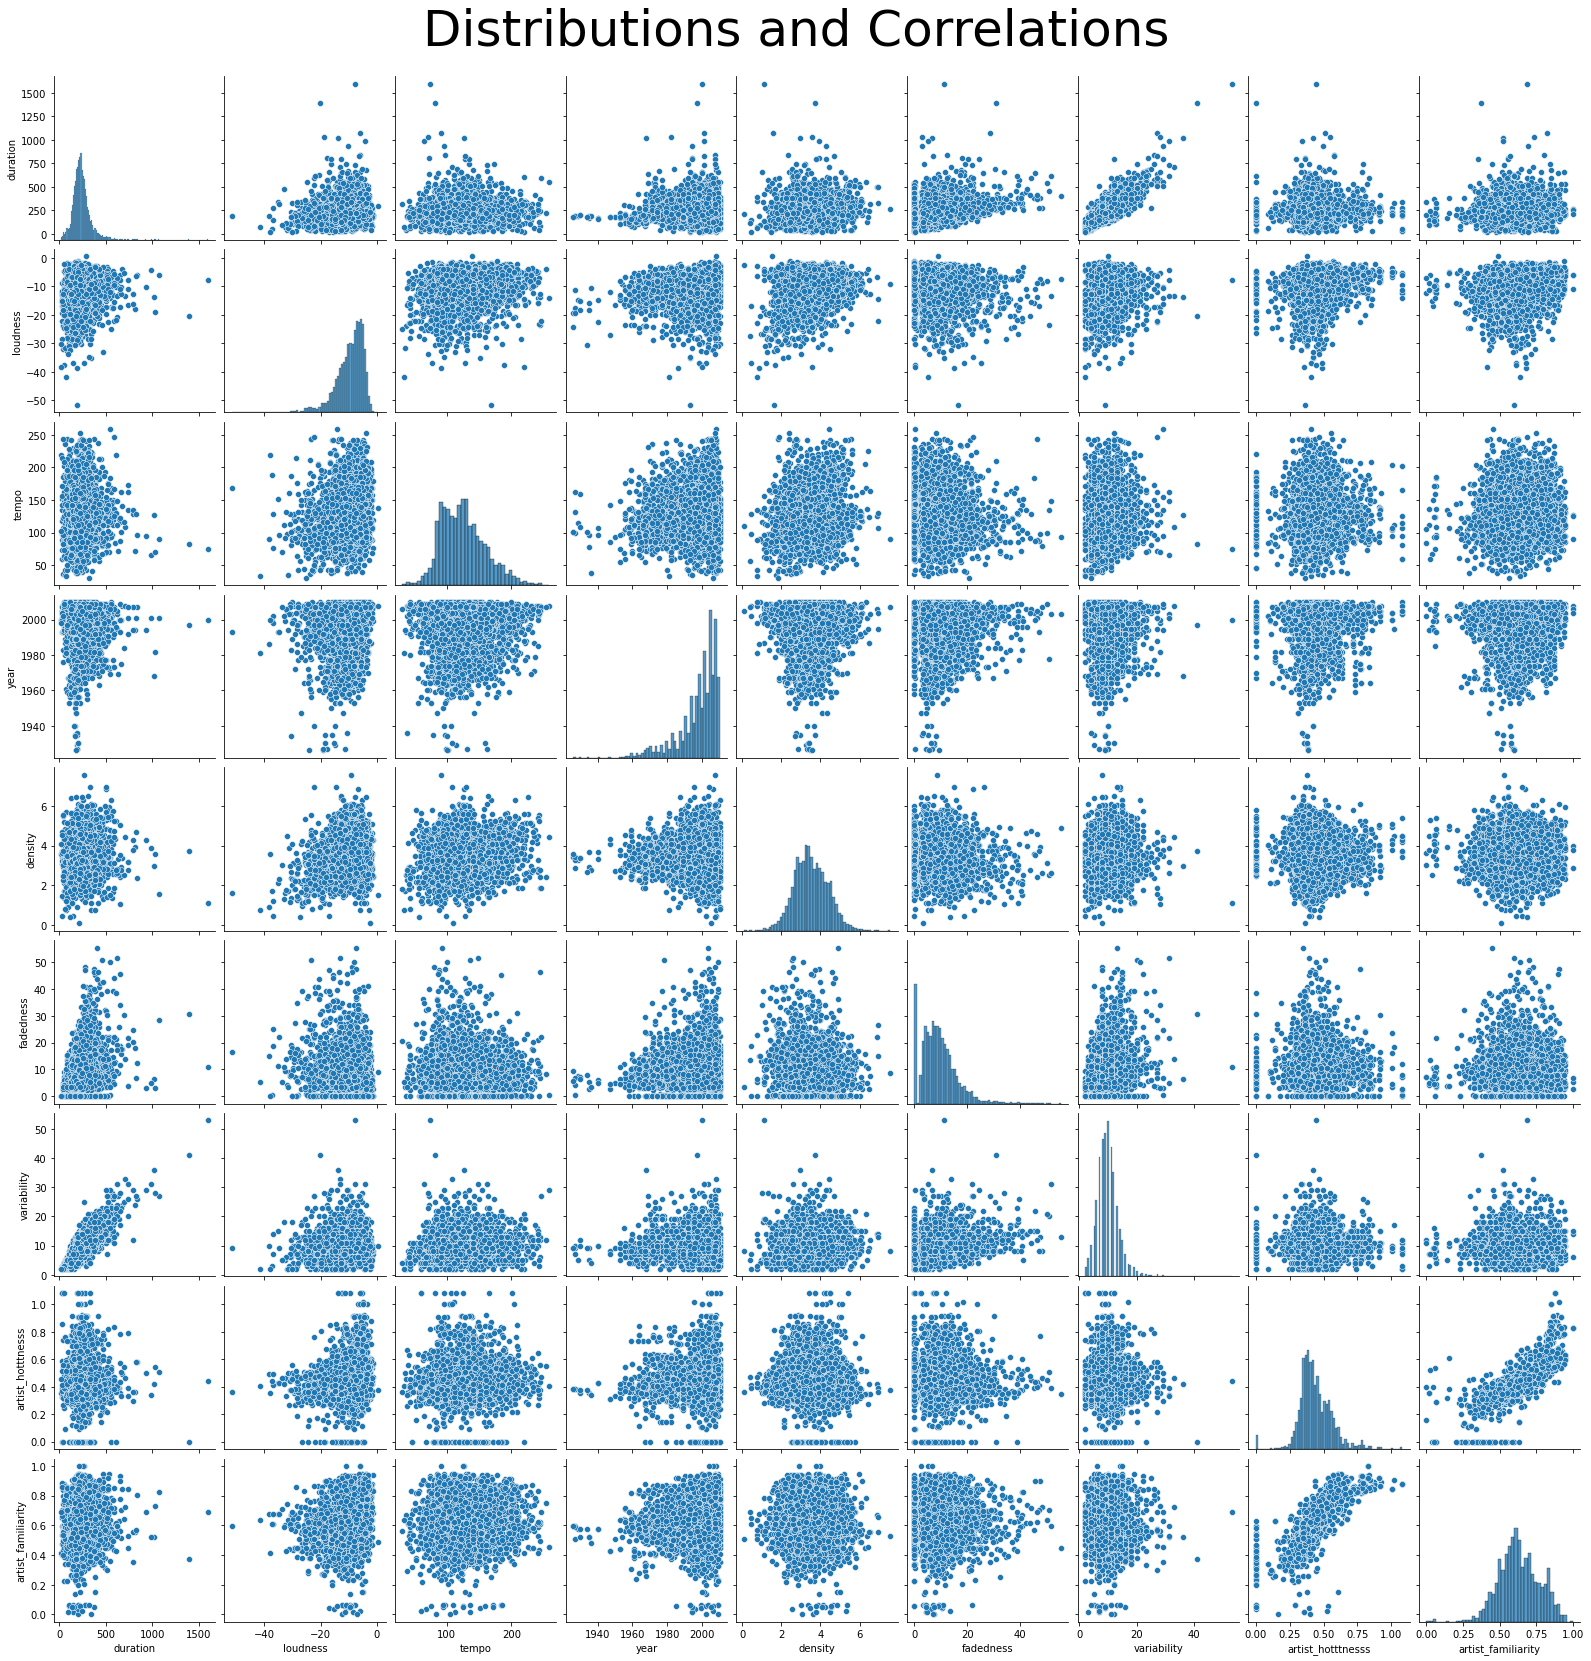

<Figure size 1440x1440 with 0 Axes>

In [63]:
# Pair plot
pp = sns.pairplot(df_filtered)

plt.suptitle("Distributions and Correlations", fontsize=50, fontweight="regular", x = 0.5, y = 1.03)
# sns.set_context("notebook", font_scale=10, labelsize=10)
plt.figure(figsize=(20,20))
plt.show()

/var/folders/bh/37q8tg8s5lzdynsgpklkf_k00000gn/T/ipykernel_70088/624434728.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


Text(0.45, 1.1, 'Correlation Heatmap')

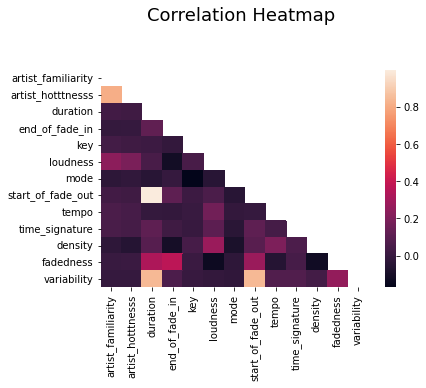

In [137]:
corr_matrix = df.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix,mask=mask)
plt.suptitle("Correlation Heatmap", fontsize=18, fontweight="normal", x = 0.45, y = 1.1)

In [77]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", yscale_log=False):

    # Create the plot object
    _, ax = plt.subplots()

    # Plot the data, set the size (s), color and transparency (alpha)
    # of the points
    ax.scatter(x_data, y_data, s = 10, alpha = 0.75)

    if yscale_log == True:
        ax.set_yscale('log')

    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

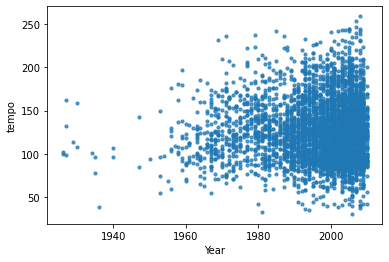

In [78]:
scatterplot(df_filtered['year'], df_filtered['tempo'], x_label='Year', y_label='tempo')

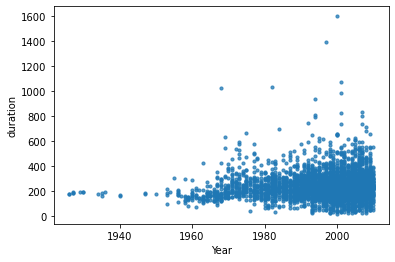

In [79]:
scatterplot(df_filtered['year'], df_filtered['duration'], x_label='Year', y_label='duration')

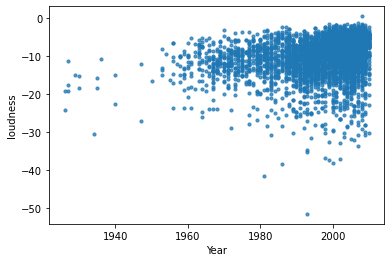

In [80]:
scatterplot(df_filtered['year'], df_filtered['loudness'], x_label='Year', y_label='loudness')

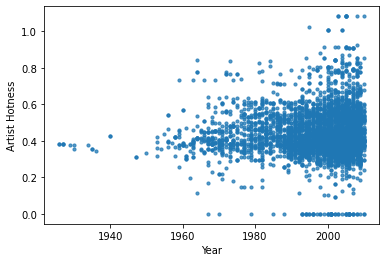

In [139]:
scatterplot(df_filtered['year'], df_filtered['artist_hotttnesss'], x_label='Year', y_label='Artist Hotness')

In [106]:
df_gy = df.merge(df_year, on='track_id')

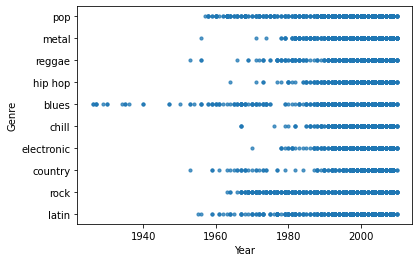

In [110]:
scatterplot(df_gy['year'], df_gy['genre'], x_label='Year', y_label='Genre')

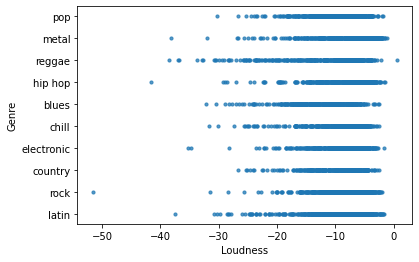

In [114]:
scatterplot(df_gy['loudness_x'], df_gy['genre'], x_label='Loudness', y_label='Genre')

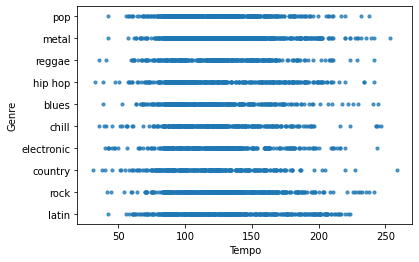

In [115]:
scatterplot(df_gy['tempo_y'], df_gy['genre'], x_label='Tempo', y_label='Genre')

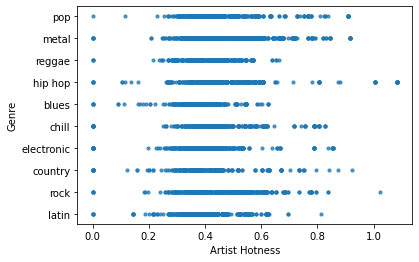

In [119]:
scatterplot(df_gy['artist_hotttnesss_x'], df_gy['genre'], x_label='Artist Hotness', y_label='Genre')

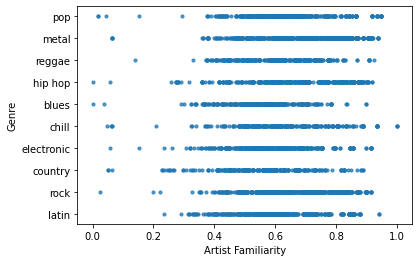

In [120]:
scatterplot(df_gy['artist_familiarity_x'], df_gy['genre'], x_label='Artist Familiarity', y_label='Genre')

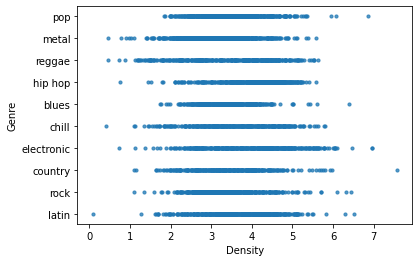

In [122]:
scatterplot(df_gy['density_x'], df_gy['genre'], x_label='Density', y_label='Genre')

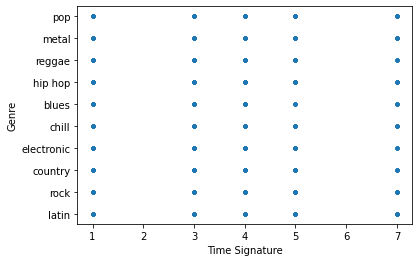

In [123]:
scatterplot(df_gy['time_signature_x'], df_gy['genre'], x_label='Time Signature', y_label='Genre')

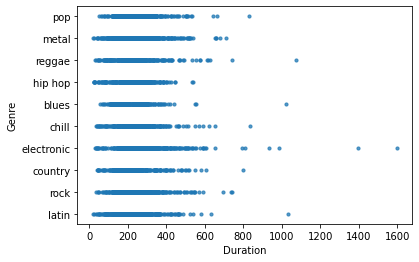

In [124]:
scatterplot(df_gy['duration_x'], df_gy['genre'], x_label='Duration', y_label='Genre')

In [112]:
df_gy.columns

Index(['artist_familiarity_x', 'artist_hotttnesss_x', 'artist_id_x',
       'artist_name_x', 'release_x', 'title_x', 'duration_x',
       'end_of_fade_in_x', 'key_x', 'loudness_x', 'mode_x',
       'start_of_fade_out_x', 'tempo_x', 'time_signature_x', 'track_id',
       'artist_terms_x', 'density_x', 'fadedness_x', 'variability_x',
       'key_string_x', 'mode_string_x', 'tonality_x', 'avg_bars_start_x',
       'avg_beats_start_x', 'genre', 'artist_familiarity_y',
       'artist_hotttnesss_y', 'artist_id_y', 'artist_name_y', 'release_y',
       'title_y', 'duration_y', 'end_of_fade_in_y', 'key_y', 'loudness_y',
       'mode_y', 'start_of_fade_out_y', 'tempo_y', 'time_signature_y', 'year',
       'artist_terms_y', 'density_y', 'fadedness_y', 'variability_y',
       'key_string_y', 'mode_string_y', 'tonality_y', 'avg_bars_start_y',
       'avg_beats_start_y'],
      dtype='object')

In [134]:
df

,artist_familiarity,artist_hotttnesss,artist_id,artist_name,release,title,duration,end_of_fade_in,key,loudness,...,artist_terms,density,fadedness,variability,key_string,mode_string,tonality,avg_bars_start,avg_beats_start,genre
0,0.558090,0.349841,ARADF5Q1187B98DAE7,Francisco Céspedes,Vida loca,Señora (bonus track),204.53832,0.572,10,-9.840,...,"[los angeles, latin pop, bolero, cuba, disco, ...",2.860100,11.57732,11,LA#,maj,LA# maj,96.38165306818182,98.76446085399449,latin
1,0.485108,0.247341,ARU22AM1187B9961EA,React,Deus Ex Machina,Lost Circles,158.27546,0.172,8,-9.680,...,"[happy hardcore, europop, progressive house, n...",3.392819,6.95446,7,SOL#,maj,SOL# maj,78.24635164705883,78.58425564469914,electronic
2,0.830252,0.507966,ARYO9BU1187B9ADA88,Porcupine Tree,On The Sunday Of Life,Music For The Head,162.06322,1.449,5,-25.745,...,"[experimental rock, art rock, post rock, exper...",1.900493,11.23622,5,FA,maj,FA maj,78.6586212173913,78.6586212173913,rock
3,0.252652,0.309794,ARXW6QA1187B9983C0,Phantomsmasher,Phantomsmasher,Bishop Hopping,382.14485,0.276,3,-6.291,...,"[post rock, grindcore, digital hardcore, avant...",2.239988,32.29885,12,RE#,maj,RE# maj,190.7804549132948,191.3237075886525,country
4,0.927986,0.599860,ARPBTRI1187FB52457,The Game,Doctor's Advocate,Da Shit,323.08200,0.000,7,-2.253,...,"[gangster rap, hardcore rap, west coast rap, c...",3.791607,5.21800,12,SOL,maj,SOL maj,159.45340847826088,160.6727261038961,hip hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9929,0.640757,0.451219,ARMSL551187FB3F4B0,K's Choice,Paradise In Me,My Record Company,222.30159,0.531,4,-7.300,...,"[post-grunge, pop rock, alternative rock, brit...",2.595573,3.37459,9,MI,maj,MI maj,109.2862806122449,110.39954214890017,pop
9930,0.544863,0.387693,ARQN3MO1187B98A811,Channel Live,Armaghetto,Turn It Up,238.81098,0.189,7,-6.338,...,"[gangster rap, hip hop, rap, east coast rap, h...",4.983020,12.29198,8,SOL,maj,SOL maj,118.63113410810811,119.43074638069704,hip hop
9931,0.379735,0.313866,ARY1P2B1187B9B78F5,Mariano Yanani,Babies Go To Sleep,Canon In D Major (J. Pachelbel),192.41751,0.467,2,-16.922,...,"[lullaby, new wave, alternative rock, rock, punk]",2.754427,9.32451,7,RE,maj,RE maj,91.97598092783505,92.9284374168798,metal
9932,0.867259,0.547764,ARHUC691187B9AD27F,The Mars Volta,Deloused in the Comatorium,Eriatarka,380.42077,0.000,6,-3.183,...,"[experimental rock, post rock, progressive met...",2.552437,-0.00023,12,FA#,min,FA# min,190.44517833333333,191.1926428853755,rock


In [144]:
import pickle

with open('df_topics.final.pkl', 'rb') as f:
    df_topics_final = pickle.load(f)

In [145]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

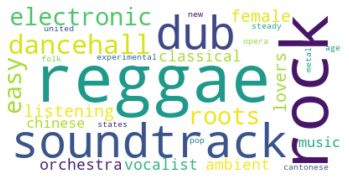

In [146]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[0]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

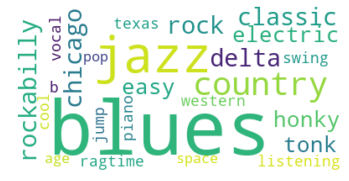

In [147]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[1]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

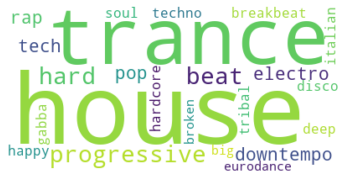

In [148]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[2]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

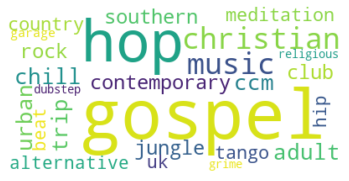

In [149]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[3]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

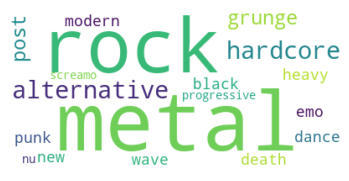

In [150]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[4]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

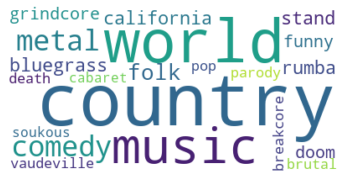

In [151]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[5]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

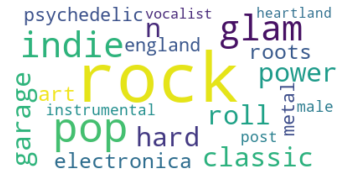

In [152]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[6]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

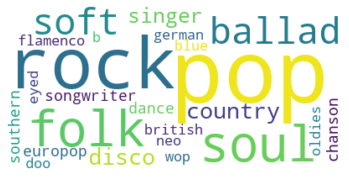

In [153]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[7]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

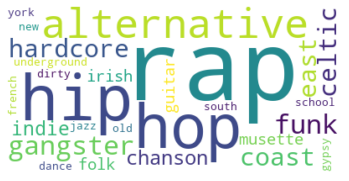

In [154]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[8]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

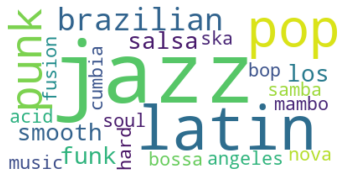

In [155]:
wc = WordCloud(
    background_color='white',
    max_words=2000
)

wc.generate(' '.join(df_topics_final[9]))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()